# Vuegen Case Study - Earth Microbiome Project

<a href="https://colab.research.google.com/github/Multiomics-Analytics-Group/vuegen/blob/main/docs/vuegen_case_study_earth_microbiome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is a demo of the Vuegen Python library. This sofwtare automates the creation of reports based on a directory with plots, dataframes, and other files in different formats. A YAML configuration file is generated from the directory to define the structure of the report. Users can customize the report by modifying the configuration file, or they can create their own configuration file instead of passing a directory as input. 

The configuration file specifies the structure of the report, including sections, subsections, and various components such as plots, dataframes, markdown, html, and API calls. Reports can be generated in various formats, including documents (PDF, HTML, DOCX, ODT), presentations (PPTX, Reveal.js), notebooks (Jupyter) or Streamlit web applications.

An overview of the VueGen workflow is shown in the figure below:

![Vuegen graphical abstarct](./images/vuegen_graph_abstract.png)

### About the data

The Earth Microbiome Project (EMP) is a systematic attempt to characterize global microbial taxonomic and functional diversity for the benefit of the planet and humankind. It aimed to sample the Earth’s microbial communities at an unprecedented scale in order to advance our understanding of the organizing biogeographic principles that govern microbial community structure. The EMP dataset is generated from samples that individual researchers have compiled and contributed to the EMP. The result is both a reference database giving global context to DNA sequence data and a framework for incorporating data from future studies, fostering increasingly complete characterization of Earth’s microbial diversity.

The data and scripts for this project are available on the [EMP GitHub repository][emp_repo], and addtional details can be found in the original article by [Thompson et al. (2017)][emp_paper].

### Notebook structure

First, we will set up the work environment by installing the necessary packages and importing the required libraries. Then, we will create various plots and tables on the exploratory data analysis, metagenomics, and network analysis sections. Next, we will create a report using Vuegen, including the plots and tables generated in the previous sections. Finally, we will extend the report by modifying the configuration file to include additional components.

0. [Work environment setup](#0-work-environment-setup)
1. [Exploratory data analysis](#1-exploratory-data-analysis)
2. [Metagenomics](#2-metagenomics)
3. [Network analysis](#3-network-analysis)
4. [Report generation](#4-report-generation)
5. [Extending the report](#5-extending-the-report)

### Credits and Contributors
- This notebook was created by Sebastián Ayala-Ruano under the supervision of Henry Webel and Alberto Santos, head of the [Multiomics Network Analytics Group (MoNA)][Mona] at the [Novo Nordisk Foundation Center for Biosustainability (DTU Biosustain)][Biosustain].
- Part of this notebook's code was inspired by the scripts and notebooks from the [EMP GitHub repository][emp_repo].
- You can find more details about the project in this [GitHub repository][githubrepo].

[emp_repo]: https://github.com/biocore/emp/tree/master
[emp_paper]: https://www.nature.com/articles/nature24621
[Mona]: https://multiomics-analytics-group.github.io/
[Biosustain]: https://www.biosustain.dtu.dk/
[githubrepo]: https://github.com/Multiomics-Analytics-Group/vuegen


## 0. Work environment setup

### 0.1. Installing libraries

In [5]:
# Install required libraries
!pip install pandas numpy plotly nbformat cartopy kaleido altair vl-convert-python seaborn biom-format networkx


[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: pip install --upgrade pip


### 0.2. Importing libraries

In [1]:
# Imports
import os
import yaml
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import plotly.graph_objects as go
import plotly.express as px
import altair as alt
import seaborn as sns

import biom
import networkx as nx

from vuegen import report_generator
from vuegen.utils import get_logger, load_yaml_config

### 0.3. Working directory

In [2]:
# Create the output directory
base_output_dir = "./example_data/Earth_microbiome_vuegen_demo_notebook/"
os.makedirs(base_output_dir, exist_ok=True)

### 0.4. Markdown project description
Create a markdown file with the project description to be displayed in the main page of the report. It is also possible to do this for the sections and subsections of the report by creating a `description.md` file in the corresponding directory.

In [3]:
# Create project description
project_description = """
The Earth Microbiome Project (EMP) is a systematic attempt to characterize global microbial taxonomic and functional diversity for the benefit of the planet and humankind. 
It aimed to sample the Earth’s microbial communities at an unprecedented scale in order to advance our understanding of the organizing biogeographic principles that govern microbial community structure. 
The EMP dataset is generated from samples that individual researchers have compiled and contributed to the EMP. 
The result is both a reference database giving global context to DNA sequence data and a framework for incorporating data from future studies, fostering increasingly complete characterization of Earth’s microbial diversity.

You can find more information about the Earth Microbiome Project at https://earthmicrobiome.org/ and in the [original article](https://www.nature.com/articles/nature24621).
"""

# Write the description to a file
with open(os.path.join(base_output_dir, "description.md"), "w") as file:
    file.write(project_description)

### 0.5. Helper functions

In [4]:
def get_empo_cat_color(empocat=None, returndict=False):
    """returns standard empo colors for EMP figures
    input:
    empocat- empo category name (string)
    returndict-  the user needs the dictionary mapping category to color (boolean)
    
    output: either a color for passed empocat or the dictionay if returndict=True"""
    
    # hex codes for matplotlib colors are described here:
    # https://github.com/matplotlib/matplotlib/blob/cf83cd5642506ef808853648b9eb409f8dbd6ff3/lib/matplotlib/_color_data.py

    empo_cat_color={'EMP sample': '#929591', # 'grey'
                    'Host-associated': '#fb9a99',
                    'Free-living': '#e31a1c',
                    'Animal': '#b2df8a',
                    'Plant': '#33a02c',
                    'Non-saline': '#a6cee3',
                    'Saline': '#1f78b4',
                    'Aerosol (non-saline)': '#d3d3d3', # 'lightgrey'
                    'Animal corpus': '#ffff00', # 'yellow'
                    'Animal distal gut': '#8b4513', # 'saddlebrown'
                    'Animal proximal gut': '#d2b48c', # 'tan'
                    'Animal secretion': '#f4a460', # 'sandybrown'
                    'Animal surface': '#b8860b', # 'darkgoldenrod'
                    'Hypersaline (saline)': '#87cefa', # 'lightskyblue'
                    'Intertidal (saline)': '#afeeee', # 'paleturquoise'
                    'Mock community': '#ff00ff', # 'fuchsia'
                    'Plant corpus': '#7cfc00', # 'lawngreen'
                    'Plant rhizosphere': '#006400', # 'darkgreen'
                    'Plant surface': '#00fa9a', # 'mediumspringgreen'
                    'Sediment (non-saline)': '#ffa07a', # 'lightsalmon'
                    'Sediment (saline)': '#ff6347', # 'tomato'
                    'Soil (non-saline)': '#ff0000', # 'red'
                    'Sterile water blank': '#ee82ee', # 'violet'
                    'Surface (non-saline)': '#000000', # 'black'
                    'Surface (saline)': '#696969', # 'dimgrey'
                    'Water (non-saline)': '#000080', # 'navy'
                    'Water (saline)': '#4169e1' # 'royalblue'
                    }
    
    if returndict==True:
        return empo_cat_color
    else:
        return empo_cat_color[empocat]

## 1. Exploratory data analysis

### 1.1. Global scope of sample provenance
Samples come from 7 continents, 43 countries, 21 biomes (ENVO), 92 environmental features (ENVO), and 17 environments (EMPO).

#### 1.1.1. Load data and create section and subsection directories

In [5]:
# Create the output directory for the EDA section and sample provenance subsection
sample_prov_output_dir = os.path.join(base_output_dir, "1_Exploratory_data_analysis/1_sample_exploration/")
os.makedirs(sample_prov_output_dir, exist_ok=True)

# Load data and filter out control samples
metadata_mapping = 'https://raw.githubusercontent.com//biocore/emp/master/data/mapping-files/emp_qiime_mapping_release1.tsv'
metadata_mapping_df = pd.read_table(metadata_mapping, index_col=0)
metadata_mapping_df = metadata_mapping_df[metadata_mapping_df['empo_1'] != 'Control']

#### 1.1.2. Random subset of the metadata dataframe

In [6]:
# Obtain a randome sample of the metadata df
sample_metadata_mapping_df = metadata_mapping_df.sample(100)

# Export the sample df as a CSV file
sample_metadata_mapping_df.to_csv(f'{sample_prov_output_dir}/1_metadata_random_subset.csv')

#### 1.1.3. Static map with matplotlib

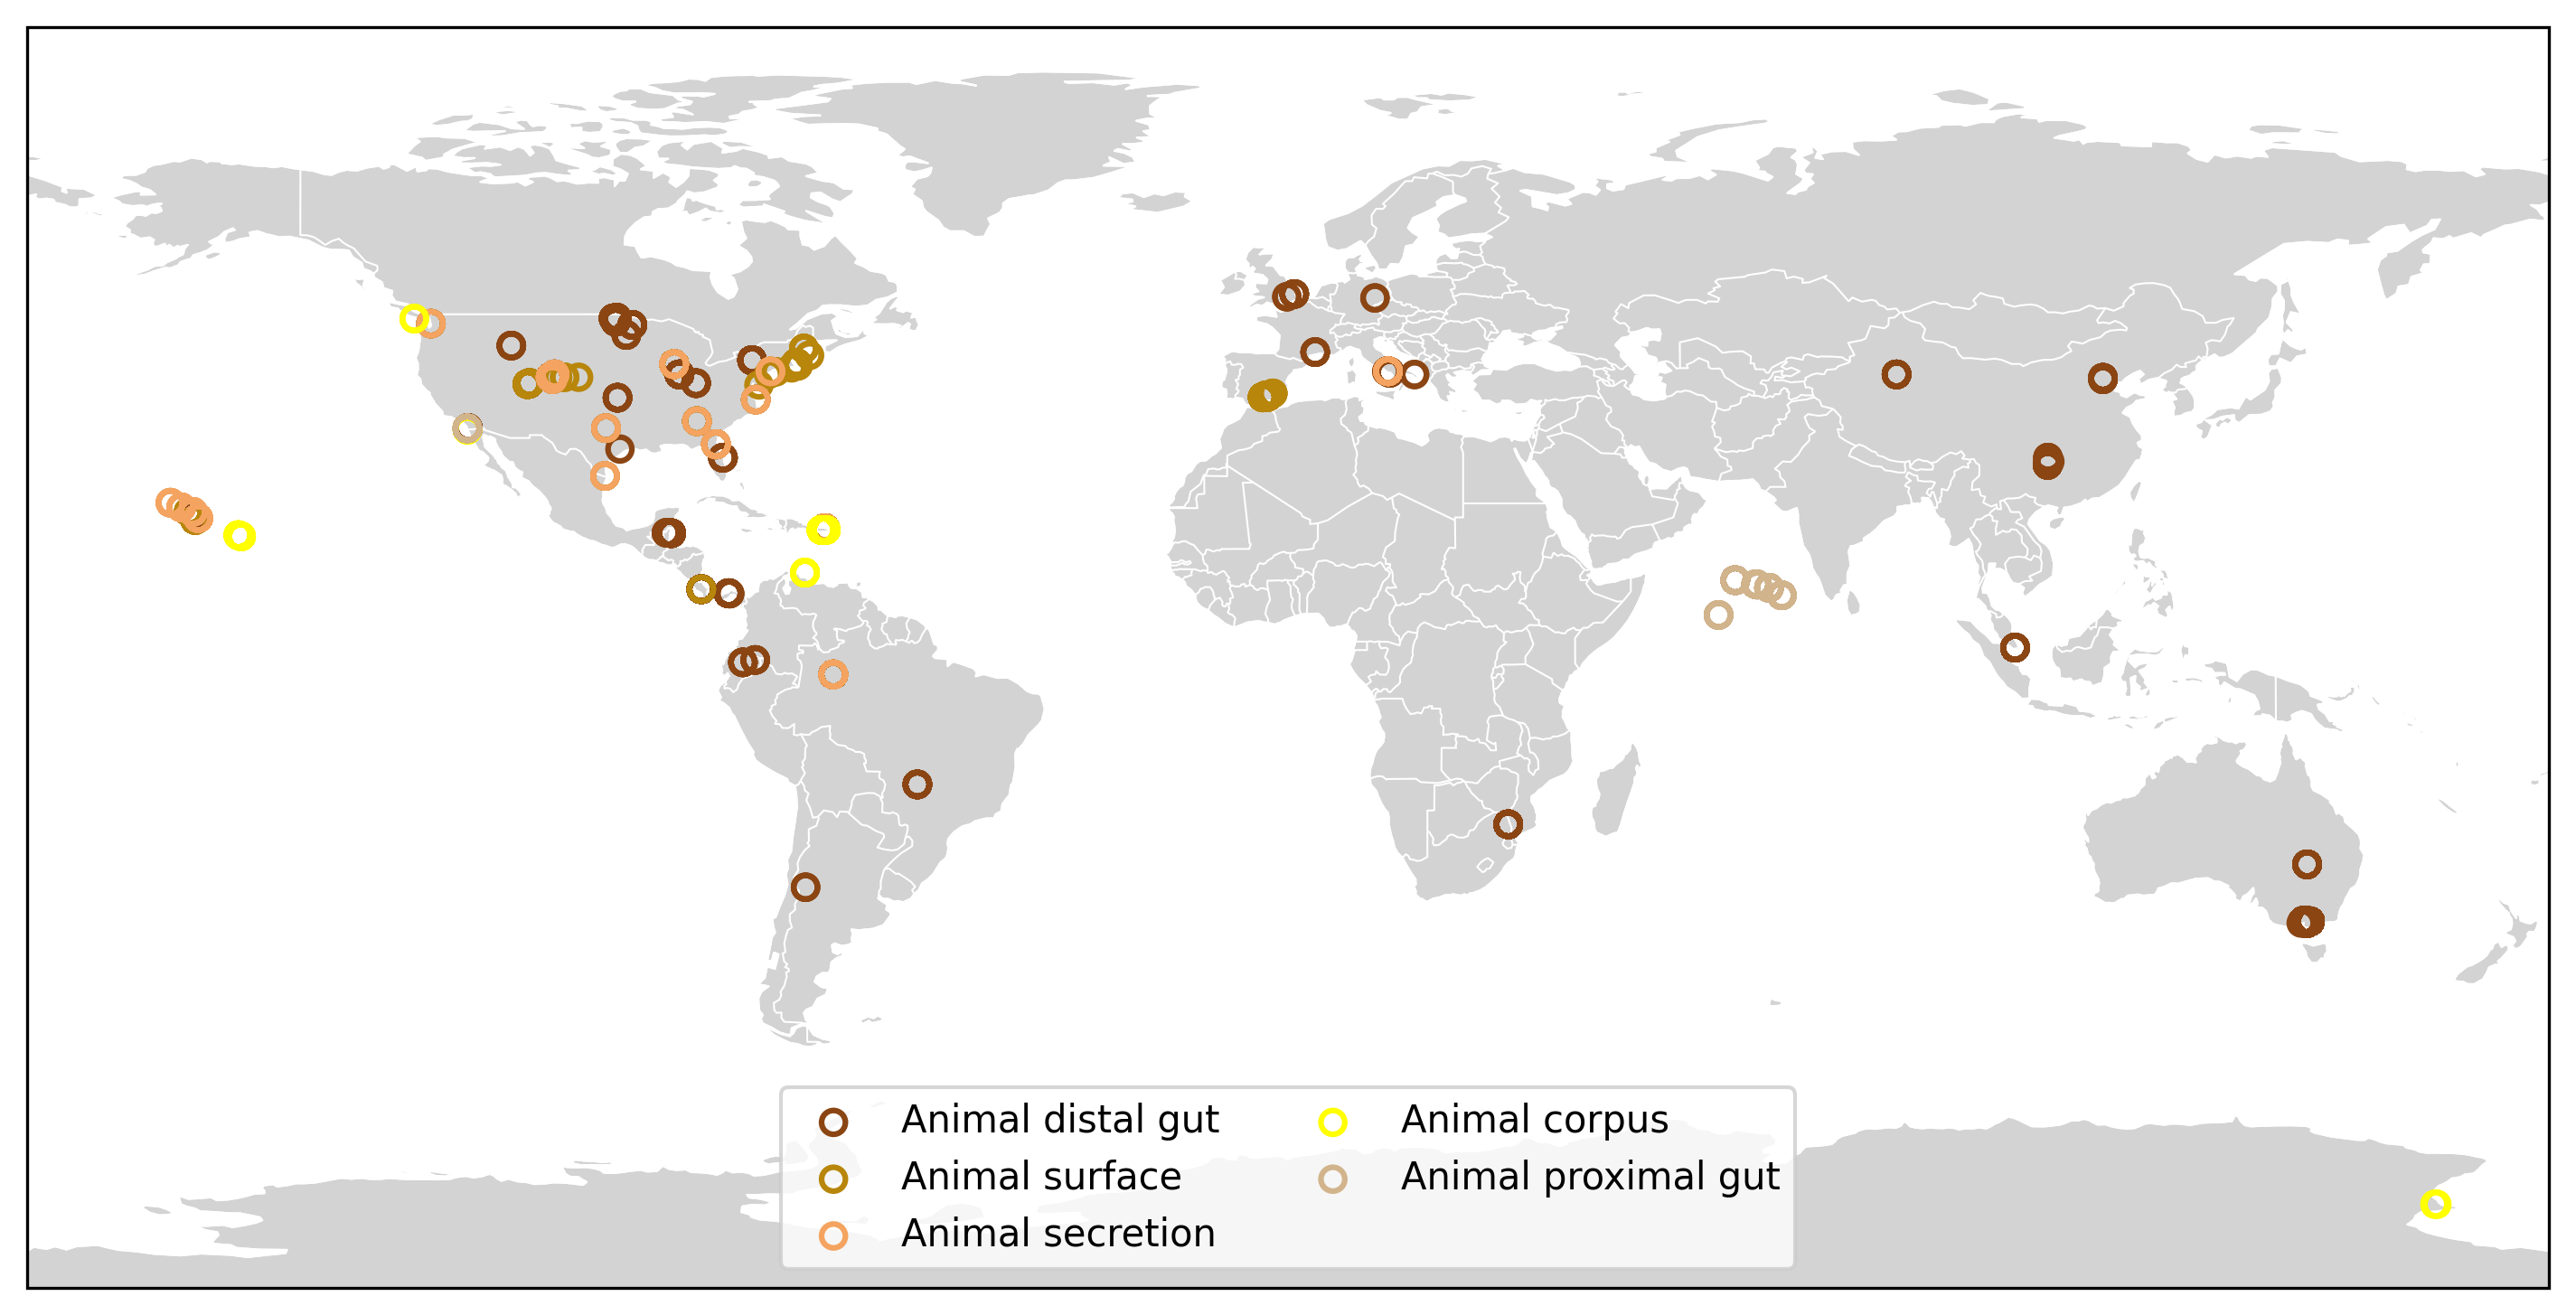

In [7]:
# Extract Animal dataset
animal_df = metadata_mapping_df[metadata_mapping_df["empo_2"] == "Animal"]

# Unique subcategories in empo_3
animal_empo3 = animal_df["empo_3"].unique()

# Create a figure with Cartopy map projection
fig, ax = plt.subplots(figsize=(12, 8), dpi=300, subplot_kw={'projection': ccrs.PlateCarree()})

# Add features to the map
ax.add_feature(cfeature.BORDERS, edgecolor='white', linewidth=0.5)
ax.add_feature(cfeature.LAND, edgecolor='white', facecolor='lightgray', linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, edgecolor='white', linewidth=0.5)

# Set extent (global map)
ax.set_extent([-180, 180, -90, 90])

# Plot each subcategory with a unique color (unfilled circles with borders)
for empo3 in animal_empo3:
    subset = animal_df[animal_df["empo_3"] == empo3]
    color = get_empo_cat_color(empo3)  # Get color for category
    ax.scatter(subset["longitude_deg"], subset["latitude_deg"], 
               color='none', edgecolors=color, linewidth=1.5, label=empo3, s=40, 
               transform=ccrs.PlateCarree(), zorder=2)

# Add legend with updated labels
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='lower center', ncol=2, fontsize=10)

# Save the figure
animal_map_out_path = os.path.join(sample_prov_output_dir, "2_animal_samples_map.png")
plt.savefig(animal_map_out_path, dpi=300, bbox_inches="tight")

#### 1.1.4. Interactive map with plotly

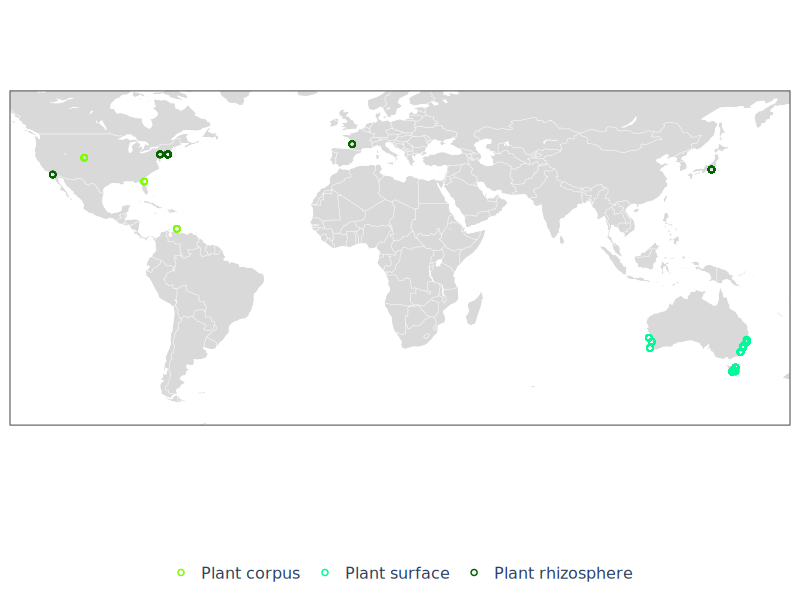

In [8]:
# Extract Plant dataset
plant_df = metadata_mapping_df[metadata_mapping_df['empo_2'] == 'Plant']

# Unique subcategories in empo_3
plant_empo3 = plant_df["empo_3"].unique()

# Create a base map figure
fig = go.Figure()

# Plot each subcategory with unique color (unfilled circles with borders)
for empo3 in plant_empo3:
    subset = plant_df[plant_df["empo_3"] == empo3]
    color = get_empo_cat_color(empo3)  # Get color for category

    fig.add_trace(go.Scattergeo(
        lon=subset["longitude_deg"],
        lat=subset["latitude_deg"],
        mode="markers",
        marker=dict(
            symbol="circle-open",  # Unfilled circle
            color=color,
            size=6,  # Marker size
            line=dict(width=1.5, color=color)  # Border color matches category color
        ),
        name=empo3
    ))

# Update map layout (fixes horizontal blank space)
fig.update_layout(
    geo=dict(
        landcolor="rgb(217, 217, 217)",  # Light gray land color
        showcountries=True,  # Enable country borders
        countrycolor="white",  # Set country borders to white
        countrywidth=0.5,  # Border thickness
        coastlinecolor="white",
        fitbounds="locations",  # Focuses only on data points
        lataxis=dict(range=[-60, 85], showgrid=False),  # Custom latitude range
        lonaxis=dict(range=[-180, 180], showgrid=False)  # Custom longitude range
    ),
    autosize=False,
    width=800,  # Adjust width to remove blank space
    height=600,  # Keep a balanced height
    margin=dict(l=10, r=10, t=10, b=10),  # Reduce margins to keep map centered
    legend=dict(
        title="",
        font=dict(size=16),  # Legend font size
        x=0.5,  # Center legend horizontally
        xanchor="center",
        yanchor="top",
        orientation="h"  # Horizontal legend layout
    )
)

# Save the figure as SVG and JSON
# plant_map_out_path = os.path.join(sample_prov_output_dir, "2_plant_samples_map.svg")
# fig.write_image(plant_map_out_path, scale=2)

plant_map_json_path = os.path.join(sample_prov_output_dir, "3_plant_samples_map.json")
fig.write_json(plant_map_json_path)

# Show the figure
fig.show(renderer="svg")

#### 1.1.5. Interactive map with Altair

In [9]:
# Extract Saline dataset
saline_df = metadata_mapping_df[metadata_mapping_df["empo_2"] == "Saline"].copy()

# Create a dictionary for simplified category names for the legend
simplified_category_names = {
    'Water (saline)': 'Water',
    'Sediment (saline)': 'Sediment',
    'Surface (saline)': 'Surface',
    'Hypersaline (saline)': 'Hypersaline'
}

# Simplify the empo_3 names in the DataFrame for legend
saline_df['simplified_empo_3'] = saline_df['empo_3'].apply(lambda x: simplified_category_names.get(x, x))

# Apply the get_empo_cat_color function to generate the color column
saline_df['color'] = saline_df['empo_3'].apply(get_empo_cat_color)

# Create the base world map (use the CDN URL or a different base map if you prefer)
countries = alt.topo_feature('https://cdn.jsdelivr.net/npm/world-atlas@2/countries-110m.json', 'countries')

# Create a background map of countries
background_map = alt.Chart(countries).mark_geoshape(
    fill='lightgray',
    stroke='white'
).project('equirectangular').properties(
    width=800,
    height=400
)

# Create the points for saline samples with custom colors
saline_points = alt.Chart(saline_df).mark_point(size=50, shape='circle', filled=False,).encode(
    longitude='longitude_deg:Q',
    latitude='latitude_deg:Q',
    color=alt.Color('simplified_empo_3:N', 
                   scale=alt.Scale(domain=list(saline_df['simplified_empo_3'].unique()), 
                                   range=[get_empo_cat_color(cat) for cat in saline_df['empo_3'].unique()]),
                   legend=alt.Legend(
                       title='',
                       orient='bottom', 
                       symbolSize=120,
                       labelFontSize=16 
                   )),
    tooltip=['latitude_deg', 'longitude_deg', 'empo_3']
)

# Overlay the points on the world map
map_with_points = background_map + saline_points

# Save as JSON and 
saline_json_path = os.path.join(sample_prov_output_dir, "4_saline_samples_map.json")
with open(saline_json_path, "w") as f:
    f.write(map_with_points.to_json())

# saline_png_path = os.path.join(sample_prov_output_dir, "5_saline_samples_map.png")
# map_with_points.save(saline_png_path)

# Display the map
map_with_points

alt.LayerChart(...)

## 2. Metagenomics

### 2.1. Alpha diversity
The alpha diversity was measured as number of observed 90bp tag sequences (richness), in n = 23,828 biologically independent samples as a function of environment. Tag sequence counts were subsampled to 5,000 observations.

#### 2.1.1. Load data and create section and subsection directories

In [10]:
# Create the output directory for the metagenomics section and alpha diversity subsection
alpha_div_output_dir = os.path.join(base_output_dir, "2_Metagenomics/1_alpha_diversity")
os.makedirs(alpha_div_output_dir, exist_ok=True)

# Load data 
mapping_qc_filt = 'https://raw.githubusercontent.com//biocore/emp/master/data/mapping-files/emp_qiime_mapping_qc_filtered.tsv'
mapping_qc_filt_df = pd.read_csv(mapping_qc_filt, sep='\t', index_col=0, header=0).sort_index()

In [11]:
# Define colors of host associated and free living categories  
colorsHA = {
    'Animal corpus': get_empo_cat_color('Animal corpus'),
    'Plant corpus': get_empo_cat_color('Plant corpus'),
    'Animal secretion': get_empo_cat_color('Animal secretion'),
    'Plant surface': get_empo_cat_color('Plant surface'),
    'Animal proximal gut': get_empo_cat_color('Animal proximal gut'),
    'Animal surface': get_empo_cat_color('Animal surface'),
    'Animal distal gut': get_empo_cat_color('Animal distal gut'),
    'Plant rhizosphere': get_empo_cat_color('Plant rhizosphere'),
}

colorsFL = {
    'Water (saline)': get_empo_cat_color('Water (saline)'), 
    'Aerosol (non-saline)': get_empo_cat_color('Aerosol (non-saline)'), 
    'Hypersaline (saline)': get_empo_cat_color('Hypersaline (saline)'),
    'Surface (non-saline)': get_empo_cat_color('Surface (non-saline)'),  
    'Surface (saline)': get_empo_cat_color('Surface (saline)'), 
    'Water (non-saline)': get_empo_cat_color('Water (non-saline)'), 
    'Sediment (saline)': get_empo_cat_color('Sediment (saline)'), 
    'Soil (non-saline)': get_empo_cat_color('Soil (non-saline)'), 
    'Sediment (non-saline)': get_empo_cat_color('Sediment (non-saline)')
}

#### 2.1.2. Static box plot with matplotlib

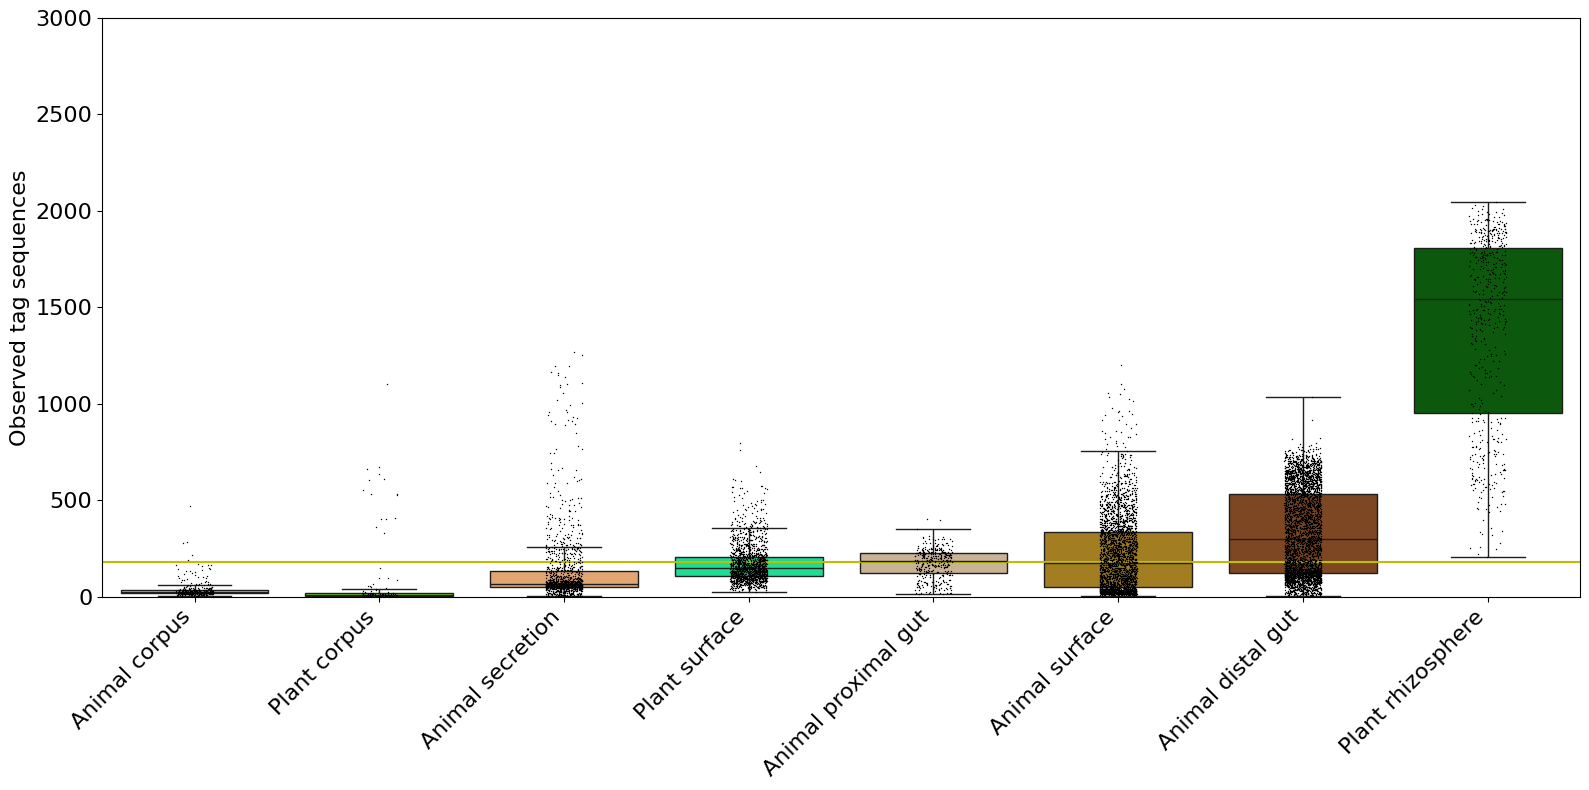

In [12]:
# Ensure y variable is numeric to avoid aggregation errors
mapping_qc_filt_df['adiv_observed_otus'] = pd.to_numeric(mapping_qc_filt_df['adiv_observed_otus'], errors='coerce')

# Get valid categories (only ones in colorsHA)
valid_categories_HA = set(colorsHA.keys())

# Filter dataset to include only valid categories
filtered_data_HA = mapping_qc_filt_df[
    (mapping_qc_filt_df['empo_0'] == 'EMP sample') &
    (mapping_qc_filt_df['empo_3'].isin(valid_categories_HA)) 
]

# Compute sorted order (only for valid categories)
sorted_order = (
    filtered_data_HA.groupby(['empo_3'])['adiv_observed_otus']
    .mean()
    .dropna()
    .sort_values()
    .index.tolist()
)

# Create palette dictionary using only valid categories
palette_dict = {cat: colorsHA[cat] for cat in sorted_order}

# Create figure for Matplotlib
fig = plt.figure(figsize=(16, 8))

# Plot the boxplot and jitter plot
sns.boxplot(fliersize=0, x='empo_3', y='adiv_observed_otus', hue='empo_3', linewidth=1, data=filtered_data_HA, 
            order=sorted_order, palette=palette_dict)
sns.stripplot(jitter=True, x='empo_3', y='adiv_observed_otus', data=filtered_data_HA, order=sorted_order, 
              color='black', size=1)

# Customize the plot
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('')
plt.ylim(0, 3000)
plt.ylabel('Observed tag sequences', fontsize=16)

# Add median line
median = filtered_data_HA['adiv_observed_otus'].median()
plt.axhline(y=median, xmin=0, xmax=1, color='y')

# Adjust layout and save the figure
plt.tight_layout()
fig.patch.set_alpha(0.0)

# Ensure directory exists before saving
os.makedirs(alpha_div_output_dir, exist_ok=True)

# Save figure
alpha_div_box_plot_host_ass = os.path.join(alpha_div_output_dir, "1_alpha_diversity_host_associated_samples.png")
plt.savefig(alpha_div_box_plot_host_ass, dpi=300, bbox_inches="tight")

#### 2.1.3. Interactive box plot with plotly

/Users/asaru/Library/Caches/pypoetry/virtualenvs/vuegen-IFxaxej_-py3.12/lib/python3.12/site-packages/plotly/express/_core.py:1992: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



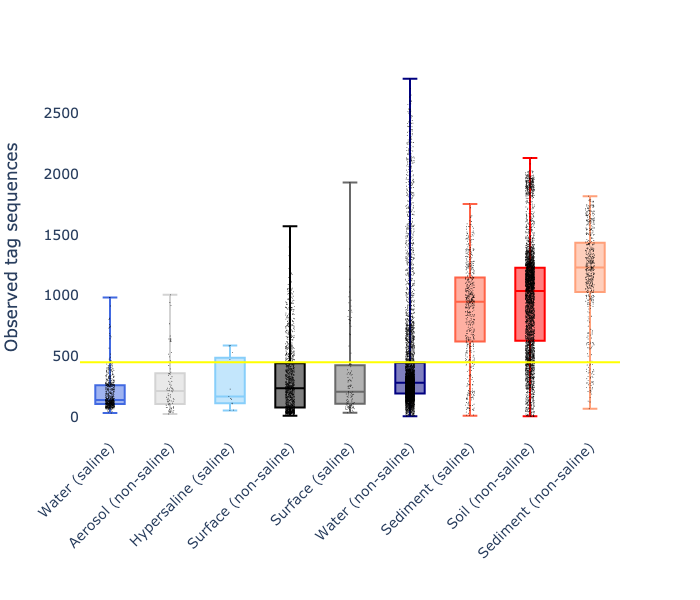

In [13]:
# Ensure y variable is numeric to avoid aggregation errors
mapping_qc_filt_df['adiv_observed_otus'] = pd.to_numeric(mapping_qc_filt_df['adiv_observed_otus'], errors='coerce')

# Get valid free-living categories (only ones in colorsFL)
valid_categories_FL = list(colorsFL.keys())

# Filter dataset to include only valid free-living categories
filtered_data_FL = mapping_qc_filt_df[
    (mapping_qc_filt_df['empo_0'] == 'EMP sample') &
    (mapping_qc_filt_df['empo_3'].isin(valid_categories_FL)) 
]

# Compute sorted order (only for valid categories)
sorted_order_FL = (
    filtered_data_FL.groupby(['empo_3'])['adiv_observed_otus']
    .mean()
    .dropna()
    .sort_values()
    .index.tolist()
)

# Create the Plotly figure using boxplot and stripplot (jittered points)
fig = px.box(
    filtered_data_FL,
    x='empo_3',
    y='adiv_observed_otus',
    color='empo_3',
    category_orders={'empo_3': sorted_order_FL},
    color_discrete_map=colorsFL,
    labels={'adiv_observed_otus': 'Observed tag sequences'},
    points=False
)

# Add jittered points (strip plot)
fig.add_trace(
    px.strip(
        filtered_data_FL,
        x='empo_3',
        y='adiv_observed_otus',
        stripmode='overlay'
    ).data[0]
)

# Modify the dot color and size directly inside the add_trace()
fig.data[-1].update(
    marker=dict(
        color='black', 
        size=1,         
        opacity=0.7     
    )
)

# Add median line
median = filtered_data_FL['adiv_observed_otus'].median()
fig.add_hline(y=median, line=dict(color='yellow'))

# Customize the plot
fig.update_layout(
    xaxis_title='',
    yaxis_title='Observed tag sequences',
    xaxis_tickangle=-45,
    plot_bgcolor='rgba(0,0,0,0)',
    showlegend=False,
    height=600,
    font=dict(size=14),
)

# Save figure as JSON
alpha_div_box_plot_free_living_json = os.path.join(alpha_div_output_dir, "2_alpha_diversity_free_living_samples.json")
fig.write_json(alpha_div_box_plot_free_living_json)

# Save figure as PNG
# alpha_div_box_plot_free_living_png = os.path.join(alpha_div_output_dir, "3_alpha_div_box_plot_free_living.png")
# fig.write_image(alpha_div_box_plot_free_living_png, width=800, height=600, scale=2)

# Show the plot
fig.show(renderer="png")

### 2.2. Gene average copy number 16S rRNA

The average copy number of the 16S rRNA gene was measured in n = 23,828 biologically independent samples as a function of environment.

#### 2.2.1. Load data and create section and subsection directories

In [14]:
# Create the output directory for the metagenomics section and average copy number subsection
avg_copy_numb_dir = os.path.join(base_output_dir, "2_Metagenomics/2_average_copy_number")
os.makedirs(avg_copy_numb_dir, exist_ok=True)

# Load data 
emp_gg_otus_sampsum = "https://raw.githubusercontent.com//biocore/emp/master/data/predicted-rrna-copy-number/emp_cr_gg_13_8.qc_filtered_filt_summary_samplesum.txt"
emp_gg_otus_sampsum_df = pd.read_csv(emp_gg_otus_sampsum, sep='\t', index_col=0, header=None).sort_index()
emp_gg_otus_norm_sampsum = "https://raw.githubusercontent.com//biocore/emp/master/data/predicted-rrna-copy-number/emp_cr_gg_13_8.normalized_qcfilt_summary_samplesum.txt"
emp_gg_otus_norm_sampsum_df = pd.read_csv(emp_gg_otus_norm_sampsum, sep='\t', index_col=0, header=None).sort_index()

In [15]:
# Create a new df by copying mapping_qc_filt_df
mapping_qc_filt_merged_df = mapping_qc_filt_df.copy()

# Merge new mapping df with emp_gg_otus_sampsum and emp_gg_otus_norm_sampsum
mapping_qc_filt_merged_df['sampsum'] = emp_gg_otus_sampsum_df[1]
mapping_qc_filt_merged_df['normsampsum'] = emp_gg_otus_norm_sampsum_df[1]
mapping_qc_filt_merged_df['copynumberdepletion'] = np.divide(emp_gg_otus_norm_sampsum_df[1], emp_gg_otus_sampsum_df[1])
mapping_qc_filt_merged_df['averagecopy'] = np.divide(1,np.divide(emp_gg_otus_norm_sampsum_df[1],emp_gg_otus_sampsum_df[1]))

#### 2.2.2. Static plot with matplotlib

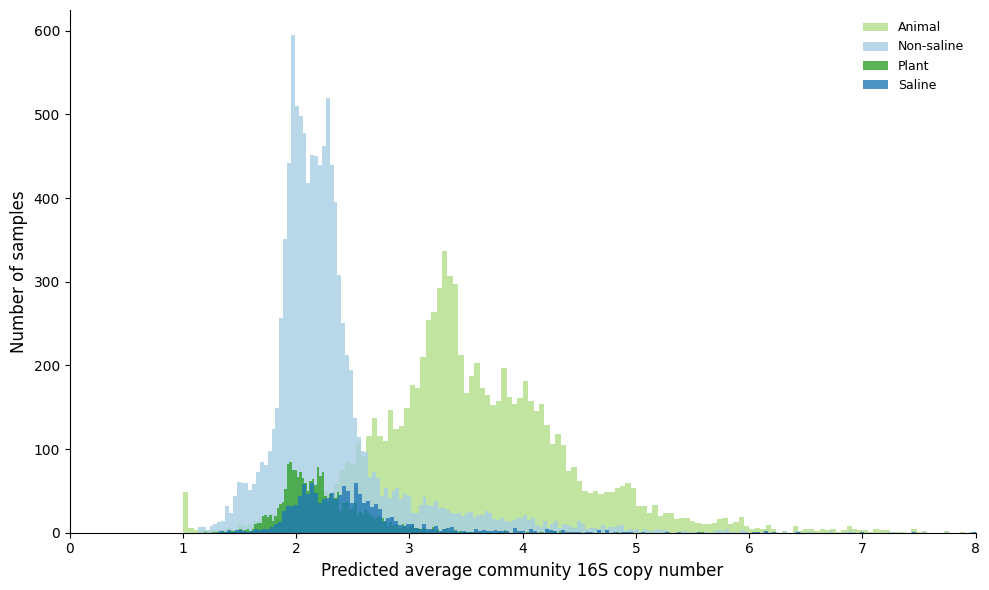

In [16]:
plt.figure(figsize=(10, 6))

for i in ['Animal', 'Non-saline', 'Plant', 'Saline']:
    plt.hist(mapping_qc_filt_merged_df[mapping_qc_filt_merged_df.empo_2 == i]['averagecopy'].dropna(), label=i,
             bins=200, linewidth=0, color=get_empo_cat_color(i), alpha=0.8)

# Customize axes: remove top and right borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Titles and labels
plt.legend(loc=1, prop={'size':9}, frameon=False)
plt.xlabel('Predicted average community 16S copy number', fontsize=12)
plt.ylabel('Number of samples', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlim([0,8])
plt.tight_layout()

# Save the figure
avg_copy_numb_empo2 = os.path.join(avg_copy_numb_dir, "1_average_copy_number_emp_ontology_level2.png")
plt.savefig(avg_copy_numb_empo2, dpi=300, bbox_inches="tight")

#### 2.2.3. Interactive plot with plotly

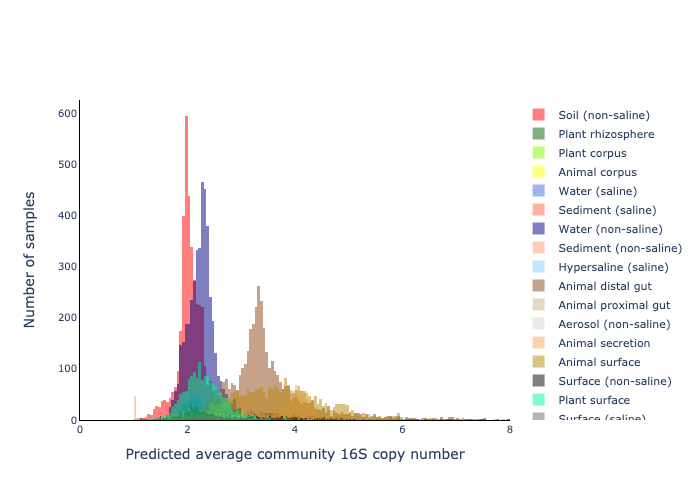

In [17]:
# Create a list to store histogram traces
hist_traces = []

# Loop through unique categories in 'empo_3'
for i in mapping_qc_filt_merged_df.empo_3.dropna().unique():
    hist_traces.append(
        go.Histogram(
            x=mapping_qc_filt_merged_df[mapping_qc_filt_merged_df.empo_3 == i]['averagecopy'].dropna(),
            name=i,  # Legend name
            marker=dict(color=get_empo_cat_color(i)),  # Assign color
            opacity=0.5,
            nbinsx=200  # Number of bins
        )
    )

# Create the figure
fig = go.Figure(hist_traces)

# Update layout to remove top and right borders
fig.update_layout(
    xaxis_title="Predicted average community 16S copy number",
    yaxis_title="Number of samples",
    xaxis=dict(
        range=[0, 8], 
        tickfont=dict(size=10),
        showline=True, 
        linewidth=1, 
        linecolor="black",
        mirror=False,   
        showgrid=False,  
        zeroline=False   
    ),
    yaxis=dict(
        tickfont=dict(size=10),
        showline=True, 
        linewidth=1, 
        linecolor="black",
        mirror=False,   
        showgrid=False, 
        zeroline=False   
    ),
    barmode="overlay",  
    showlegend=True,
    legend=dict(font=dict(size=11), borderwidth=0),  
    plot_bgcolor="white"  
)
# Save the figure as JSON
avg_copy_numb_empo3_json = os.path.join(avg_copy_numb_dir, "2_average_copy_number_emp_ontology_level3.json")
fig.write_json(avg_copy_numb_empo3_json)

# Save the figure as PNG
# avg_copy_numb_empo3_png = os.path.join(avg_copy_numb_dir, "3_avg_copy_numb_empo3.png")
# fig.write_image(avg_copy_numb_empo3_png, scale=2)

# Show the figure
fig.show(renderer="png")

### 2.3. Nestedness


#### 2.3.1. Load the data and create section and subsection directories

In [18]:
# Create the output directory for the metagenomics section and nestedness subsection
nestedness_dir = os.path.join(base_output_dir, "2_Metagenomics/3_nestedness")
os.makedirs(nestedness_dir, exist_ok=True)

# Load data
nest_phylum_allsamples = "https://raw.githubusercontent.com//biocore/emp/master/data/nestedness/nest_phylum_allsamples.csv"
nest_phylum_allsamples_df = pd.read_csv(nest_phylum_allsamples)
nest_phylum_animalsamples = "https://raw.githubusercontent.com//biocore/emp/master/data/nestedness/nest_phylum_Animal.csv"
nest_phylum_animalsamples_df = pd.read_csv(nest_phylum_animalsamples)
nest_phylum_plantsamples = "https://raw.githubusercontent.com//biocore/emp/master/data/nestedness/nest_phylum_Plant.csv"
nest_phylum_plantsamples_df = pd.read_csv(nest_phylum_plantsamples)
nest_phylum_nonsalinesamples = "https://raw.githubusercontent.com//biocore/emp/master/data/nestedness/nest_phylum_Non-saline.csv"
nest_phylum_nonsalinesamples_df = pd.read_csv(nest_phylum_nonsalinesamples)
  

#### 2.3.2. Random subset of the nestedness dataframe

In [19]:
# Obtain a randome sample of the nestedness df for all samples
sample_nest_phylum_allsamples_df = nest_phylum_allsamples_df.sample(100)

# Export the sample df as a CSV file
sample_nest_phylum_allsamples_df.to_csv(f'{nestedness_dir}/1_nestedness_random_subset.csv')

#### 2.3.3. Interactive plots with plotly

/Users/asaru/Library/Caches/pypoetry/virtualenvs/vuegen-IFxaxej_-py3.12/lib/python3.12/site-packages/plotly/express/_core.py:1992: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



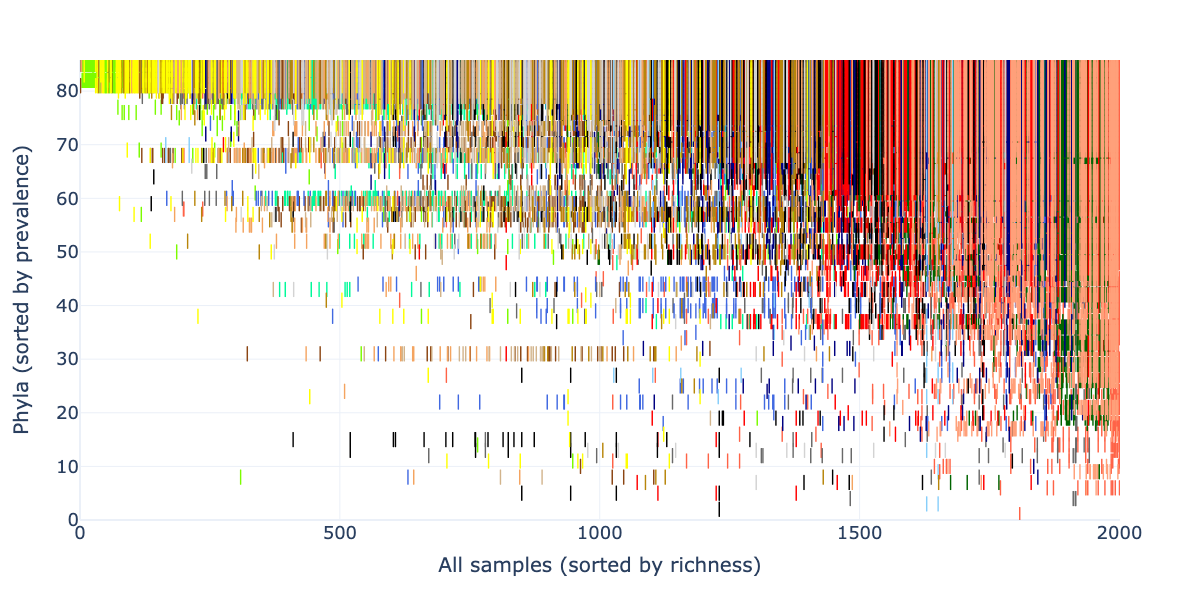

In [20]:
# Determine axis limits
xmax = nest_phylum_allsamples_df.SAMPLE_RANK.max()
ymax = nest_phylum_allsamples_df.OBSERVATION_RANK.max()

# Get colors for each empo_3 category
nest_phylum_allsamples_df['color'] = nest_phylum_allsamples_df['empo_3'].apply(get_empo_cat_color)

# Create the scatter plot
fig = px.scatter(
    nest_phylum_allsamples_df,
    x="SAMPLE_RANK",
    y="OBSERVATION_RANK",
    color="empo_3",
    color_discrete_map={empo: get_empo_cat_color(empo) for empo in nest_phylum_allsamples_df['empo_3'].unique()},
    labels={"SAMPLE_RANK": "All samples (sorted by richness)", "OBSERVATION_RANK": "Phyla (sorted by prevalence)"},
    template="plotly_white"
)

# Customize layout
fig.update_traces(marker=dict(symbol="line-ns-open", size=10))  # "|" marker equivalent
fig.update_layout(
    width=1200,  # Increase width for a wider plot
    height=600,  # Adjust height if needed
    xaxis=dict(range=[0, xmax+1], title_font=dict(size=20), tickfont=dict(size=18)),
    yaxis=dict(range=[0, ymax+0.8], title_font=dict(size=20), tickfont=dict(size=18)),
    showlegend=False
)

# Save the figure as an interactive HTML file
os.makedirs(nestedness_dir, exist_ok=True)
nest_phylum_allsamples_path = os.path.join(nestedness_dir, "2_all_samples.json")
fig.write_json(nest_phylum_allsamples_path)

# Show the figure
fig.show(renderer="png")

/Users/asaru/Library/Caches/pypoetry/virtualenvs/vuegen-IFxaxej_-py3.12/lib/python3.12/site-packages/plotly/express/_core.py:1992: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



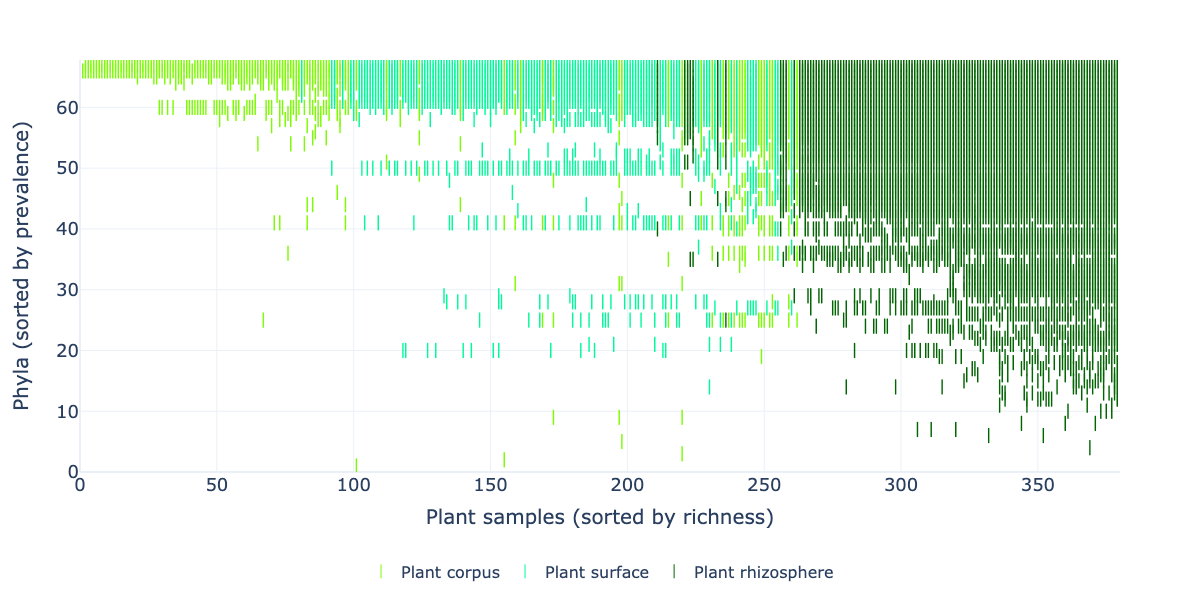

In [21]:
# Determine axis limits
xmax = nest_phylum_plantsamples_df.SAMPLE_RANK.max()
ymax = nest_phylum_plantsamples_df.OBSERVATION_RANK.max()

# Get colors for each empo_3 category
nest_phylum_plantsamples_df['color'] = nest_phylum_plantsamples_df['empo_3'].apply(get_empo_cat_color)

# Create the scatter plot
fig = px.scatter(
    nest_phylum_plantsamples_df,
    x="SAMPLE_RANK",
    y="OBSERVATION_RANK",
    color="empo_3",
    color_discrete_map={empo: get_empo_cat_color(empo) for empo in nest_phylum_plantsamples_df['empo_3'].unique()},
    labels={"SAMPLE_RANK": "Plant samples (sorted by richness)", "OBSERVATION_RANK": "Phyla (sorted by prevalence)"},
    template="plotly_white"
)

# Customize layout
fig.update_traces(marker=dict(symbol="line-ns-open", size=10))  # "|" marker equivalent
fig.update_layout(
    width=1200,  # Increase width for a wider plot
    height=600,  # Adjust height if needed
    xaxis=dict(range=[0, xmax+1], title_font=dict(size=20), tickfont=dict(size=18)),
    yaxis=dict(range=[0, ymax+0.8], title_font=dict(size=20), tickfont=dict(size=18)),
    legend=dict(
        orientation="h",  # Horizontal legend
        yanchor="top", y=-0.2,  # Moves the legend below the x-axis
        xanchor="center", x=0.5,  # Centers the legend
        font=dict(size=16)
    ),
    legend_title_text=""
)

# Save the figure as an interactive HTML file
os.makedirs(nestedness_dir, exist_ok=True)
nest_phylum_plantsamples_path = os.path.join(nestedness_dir, "3_plant_samples.json")
fig.write_json(nest_phylum_plantsamples_path)

# Show the figure
fig.show(renderer="png")

#### 2.3.4. Static plots with matplotlib

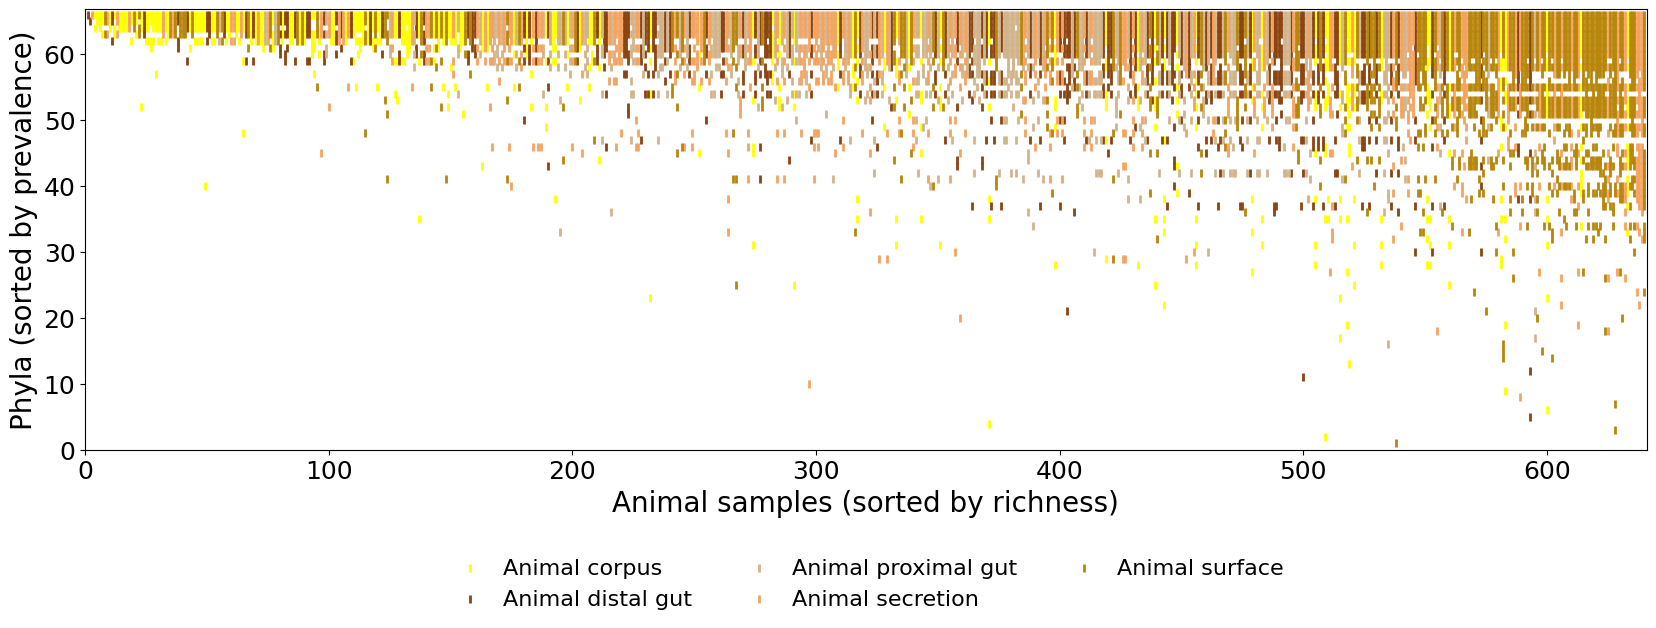

In [22]:
# Determine axis limits
xmax = nest_phylum_animalsamples_df.SAMPLE_RANK.max()
ymax = nest_phylum_animalsamples_df.OBSERVATION_RANK.max()

# Create the figure and axis
fig, ax = plt.subplots(figsize=(500/30, 80/12.7))  # Adjust size as needed

# Store legend handles and labels
legend_handles = []
legend_labels = []

# Plot data
for empo3 in np.sort(nest_phylum_animalsamples_df.empo_3.unique()):
    color = get_empo_cat_color(empo3)
    scatter = ax.scatter(
        nest_phylum_animalsamples_df[nest_phylum_animalsamples_df.empo_3 == empo3].SAMPLE_RANK, 
        nest_phylum_animalsamples_df[nest_phylum_animalsamples_df.empo_3 == empo3].OBSERVATION_RANK, 
        marker='|', linewidths=2, label=empo3, color=color
    )
    legend_handles.append(scatter)
    legend_labels.append(empo3)

# Customize labels and appearance
ax.set_xlabel("Animal samples (sorted by richness)", fontsize=20)
ax.set_ylabel("Phyla (sorted by prevalence)", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)

# Add legend
ax.legend(
    handles=legend_handles, labels=legend_labels,
    loc='upper center', bbox_to_anchor=(0.5, -0.2),  # Moves legend below x-axis
    ncol=3, fontsize=16, frameon=False, scatterpoints=1, handletextpad=0.5
)

# Increase space at the bottom so the legend is not cut off
plt.subplots_adjust(bottom=0.25)

ax.set_xlim([0, xmax+1])
ax.set_ylim([0, ymax+0.8])

plt.tight_layout()
fig.patch.set_alpha(0.0)

# Save the figure
os.makedirs(nestedness_dir, exist_ok=True)
nest_phylum_animalsamples_path = os.path.join(nestedness_dir, "4_animal_samples.png")
plt.savefig(nest_phylum_animalsamples_path, dpi=300, bbox_inches="tight")

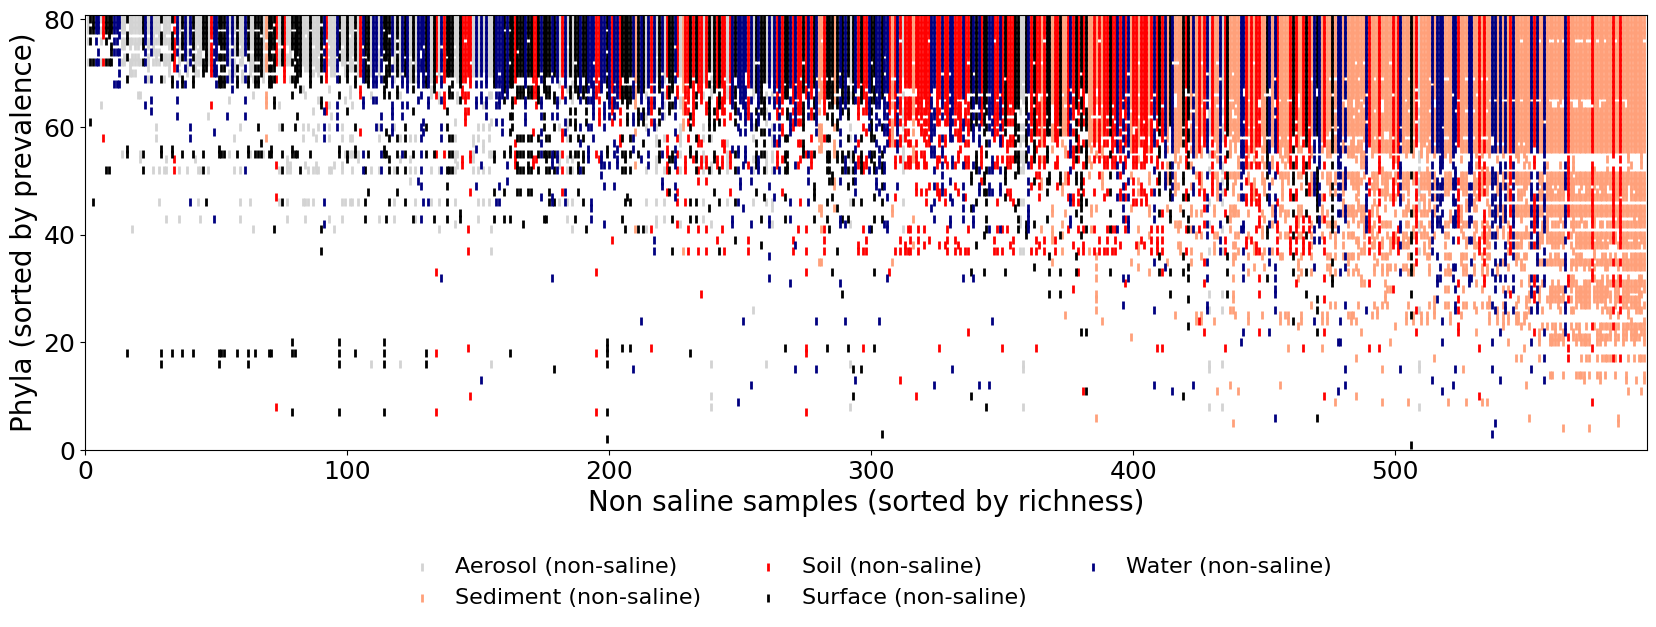

In [23]:
# Determine axis limits
xmax = nest_phylum_nonsalinesamples_df.SAMPLE_RANK.max()
ymax = nest_phylum_nonsalinesamples_df.OBSERVATION_RANK.max()

# Create the figure and axis
fig, ax = plt.subplots(figsize=(500/30, 80/12.7))  # Adjust size as needed

# Store legend handles and labels
legend_handles = []
legend_labels = []

# Plot data
for empo3 in np.sort(nest_phylum_nonsalinesamples_df.empo_3.unique()):
    color = get_empo_cat_color(empo3)
    scatter = ax.scatter(
        nest_phylum_nonsalinesamples_df[nest_phylum_nonsalinesamples_df.empo_3 == empo3].SAMPLE_RANK, 
        nest_phylum_nonsalinesamples_df[nest_phylum_nonsalinesamples_df.empo_3 == empo3].OBSERVATION_RANK, 
        marker='|', linewidths=2, label=empo3, color=color
    )
    legend_handles.append(scatter)
    legend_labels.append(empo3)

# Customize labels and appearance
ax.set_xlabel("Non saline samples (sorted by richness)", fontsize=20)
ax.set_ylabel("Phyla (sorted by prevalence)", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)

# Add legend
ax.legend(
    handles=legend_handles, labels=legend_labels,
    loc='upper center', bbox_to_anchor=(0.5, -0.2),  # Moves legend below x-axis
    ncol=3, fontsize=16, frameon=False, scatterpoints=1, handletextpad=0.5
)

# Increase space at the bottom so the legend is not cut off
plt.subplots_adjust(bottom=0.25)

ax.set_xlim([0, xmax+1])
ax.set_ylim([0, ymax+0.8])

plt.tight_layout()
fig.patch.set_alpha(0.0)

# Save the figure
os.makedirs(nestedness_dir, exist_ok=True)
nest_phylum_nonsalinesamples_path = os.path.join(nestedness_dir, "5_non_saline_samples.png")
plt.savefig(nest_phylum_nonsalinesamples_path, dpi=300, bbox_inches="tight")

## 3. Network analysis

### 3.1. Phyla association networks 

#### 3.1.1 Load data and create section and subsection directories

In [9]:
# Create the output directory for the network analysis section and microbial networks subsection
network_dir = os.path.join(base_output_dir, "3_Network_analysis/1_phyla_association_networks")
os.makedirs(network_dir, exist_ok=True)

# Load OTU counts table
otu_counts = "https://raw.githubusercontent.com//biocore/emp/master/data/biom-tables/emp_deblur_100bp.subset_2k.rare_5000.biom"

# Download the file and save it as a binary file
response = requests.get(otu_counts)
with open("example_data/Earth_microbiome_vuegen_demo_notebook/emp_deblur_100bp.subset_2k.rare_5000.biom", 'wb') as f:
    f.write(response.content)

# Load the BIOM file and convert it to a DataFrame
otu_counts_table = biom.load_table("example_data/Earth_microbiome_vuegen_demo_notebook/emp_deblur_100bp.subset_2k.rare_5000.biom")

[2025-01-29 13:44:30,905] urllib3.connectionpool: DEBUG - Starting new HTTPS connection (1): raw.githubusercontent.com:443
[2025-01-29 13:44:30,948] urllib3.connectionpool: DEBUG - https://raw.githubusercontent.com:443 "GET /biocore/emp/master/data/biom-tables/emp_deblur_100bp.subset_2k.rare_5000.biom HTTP/11" 200 60358418
[2025-01-29 13:44:31,857] h5py._conv: DEBUG - Creating converter from 3 to 5


In [10]:
# Collapse the table to the phylum level
phylum_idx = 1
collapse_f = lambda id_, md: '; '.join(md['taxonomy'][:phylum_idx + 1])
phyla_table = otu_counts_table.collapse(collapse_f, axis='observation')

# Convert the collapsed table to a DataFrame
phyla_counts_df = phyla_table.to_dataframe()

#### 3.1.2. Clean data and export a subset of the counts table

In [11]:
# Clean the index (which contains Phylum names) by removing unnecessary parts
phyla_counts_df.index = phyla_counts_df.index.str.split(';').str[-1].str.replace('p__', '', regex=False)

# Remove special characters like [] and unnecessary spaces
phyla_counts_df.index = phyla_counts_df.index.str.replace('[', '', regex=False).str.replace(']', '', regex=False).str.strip()

# Remove rows where the index only has 'k__' and 'Unclassified'
phyla_counts_df = phyla_counts_df[~(phyla_counts_df.index == 'Unclassified')]
phyla_counts_df = phyla_counts_df[~phyla_counts_df.index.str.contains('k__')]

# Remove duplicaye rows
phyla_counts_df = phyla_counts_df[~phyla_counts_df.index.duplicated(keep='first')]


In [12]:
# Obtain a randome sample of the columns of the phyla counts df
sample_phyla_counts_df = phyla_counts_df.sample(50, axis=1)

# Export the sample df as a CSV file
sample_phyla_counts_df.to_csv(f'{network_dir}/1_phyla_counts_subset.csv')

#### 3.1.3. Phyla association network edge list

In [13]:
# Compute correlation matrix with absolute values
phyla_corr_matrix = phyla_counts_df.T.corr().abs()

# Create a binary adjacency matrix using a threshold
threshold = 0.5
phyla_corr_matrix_binary = phyla_corr_matrix > threshold

# Set diagonal values to 0
np.fill_diagonal(phyla_corr_matrix_binary.values, 0)

In [14]:
# Create a graph from the binary matrix
G = nx.Graph()

# Add nodes (Phyla)
phyla = phyla_corr_matrix_binary.index.tolist()
G.add_nodes_from(phyla)

# Add edges where binary_matrix == 1
for i in range(len(phyla)):
    for j in range(i + 1, len(phyla)):  # Avoid duplicate edges
        if phyla_corr_matrix_binary.iloc[i, j] == 1:
            G.add_edge(phyla[i], phyla[j])

# Remove singleton nodes (nodes with no edges)
G.remove_nodes_from(list(nx.isolates(G)))

# Export network as an edge list in CSV format, the "edge_list" word should be in the file name to be 
# recognized as an edge list file
edge_list = nx.to_pandas_edgelist(G)
edge_list.to_csv(os.path.join(network_dir, "2_phyla_correlation_network_with_0.5_threshold_edgelist.csv"), index=False)

#### 3.1.4. Phyla association network static plot

[2025-01-29 13:44:58,341] matplotlib.pyplot: DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
[2025-01-29 13:44:58,344] matplotlib.pyplot: DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.


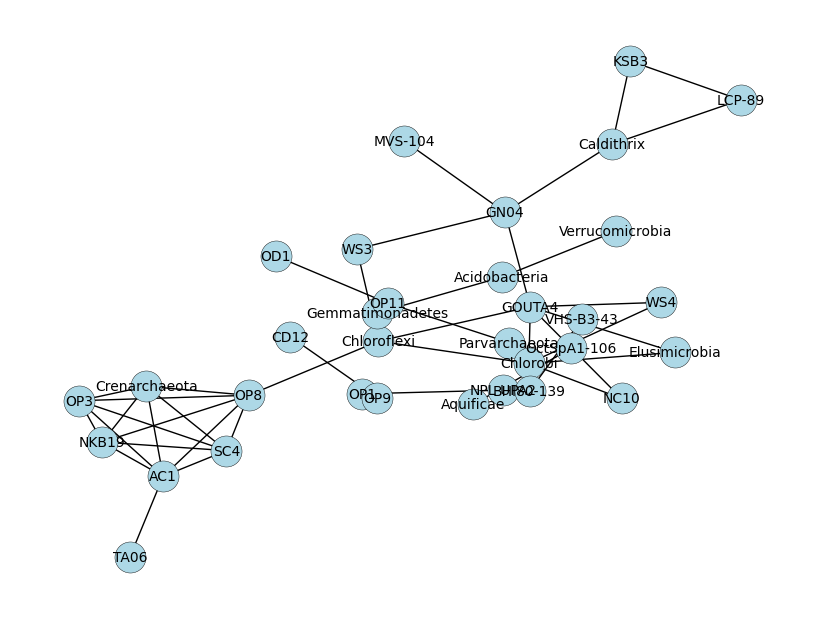

In [15]:
# Draw the network 
plt.figure(figsize=(8, 6))
pos = nx.kamada_kawai_layout(G)  # Layout for better visualization
nx.draw(G, pos, 
        with_labels=True, 
        node_size=500, 
        node_color="lightblue",  
        edgecolors="black",
        linewidths=0.3, 
        font_size=10)

# Export the figure as a PNG file
network_path = os.path.join(network_dir, "3_phyla_correlation_network_with_0.5_threshold.png")
plt.savefig(network_path, dpi=300, bbox_inches="tight")

## 4. Report generation
To generate different report types, just modify the report_type variable. The available types are: 
* streamlit
* html
* pdf
* docx
* odt
* revealjs
* pptx
* jupyter

### 4.1. Streamlit report

In [17]:
report_type = "streamlit"
report_name = "Earth_microbiome_vuegen_demo_notebook_dir"

# Initialize logger
logger = get_logger(f"{report_type}_report_{report_name}")

# Generate the report
report_generator.get_report(dir_path = base_output_dir, report_type = report_type, logger = logger)

[2025-01-29 13:45:18,515] root: INFO - Path to log file: logs/2025129_134518_streamlit_report_Earth_microbiome_vuegen_demo_notebook_dir.log
[2025-01-29 13:45:18,592] root: INFO - Report 'Earth Microbiome Vuegen Demo Notebook' initialized with 3 sections.
[2025-01-29 13:45:18,592] root: DEBUG - Generating 'streamlit' report in directory: 'streamlit_report/sections'
[2025-01-29 13:45:18,592] root: INFO - Output directory already existed: 'streamlit_report/sections'
[2025-01-29 13:45:18,593] root: INFO - Output directory for static content already existed: 'streamlit_report/static'
[2025-01-29 13:45:18,593] root: DEBUG - Processing app navigation code.
[2025-01-29 13:45:18,593] root: DEBUG - Processing home section.
[2025-01-29 13:45:18,594] root: DEBUG - Home directory already existed: streamlit_report/sections/Home
[2025-01-29 13:45:18,595] root: INFO - Home page content written to 'streamlit_report/sections/Home/Homepage.py'.
[2025-01-29 13:45:18,595] root: INFO - Home page added to th

In [18]:
!streamlit run streamlit_report/sections/report_manager.py


  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://10.75.2.65:8501

^C
  Stopping...


### 4.2. HTML report

In [19]:
report_type = "html"
report_name = "Earth_microbiome_vuegen_demo_notebook_dir"

# Initialize logger
logger = get_logger(f"{report_type}_report_{report_name}")

# Generate the report
report_generator.get_report(dir_path = base_output_dir, report_type = report_type, logger = logger)

[2025-01-29 13:45:36,807] root: INFO - Path to log file: logs/2025129_134536_html_report_Earth_microbiome_vuegen_demo_notebook_dir.log
[2025-01-29 13:45:36,882] root: INFO - Report 'Earth Microbiome Vuegen Demo Notebook' initialized with 3 sections.
[2025-01-29 13:45:36,883] root: DEBUG - Generating 'html' report in directory: 'quarto_report'
[2025-01-29 13:45:36,883] root: DEBUG - Output directory already existed: 'quarto_report'
[2025-01-29 13:45:36,883] root: INFO - Output directory for static content already existed: 'quarto_report/static'
[2025-01-29 13:45:36,884] root: INFO - Starting to generate sections for the report.
[2025-01-29 13:45:36,884] root: DEBUG - Processing section: 'Exploratory Data Analysis' - 1 subsection(s)
[2025-01-29 13:45:36,884] root: DEBUG - Processing subsection: 'Sample Exploration' - 4 component(s)
[2025-01-29 13:45:36,885] root: INFO - Successfully generated content for DataFrame: 'Metadata Random Subset'
[2025-01-29 13:45:36,885] root: INFO - Successfu


Starting python3 kernel...Done

Executing 'quarto_report.quarto_ipynb'
  Cell 1/10: 'Imports'......................................Done
  Cell 2/10: 'Metadata Random Subset 10'....................Done
  Cell 3/10: 'Plant Samples Map 43'.........................Done
  Cell 4/10: 'Saline Samples Map 44'........................Done
  Cell 5/10: 'Alpha Diversity Free Living Samples 46'.......Done
  Cell 6/10: 'Average Copy Number Emp Ontology Level3 48'...Done
  Cell 7/10: 'Nestedness Random Subset 11'..................Done
  Cell 8/10: 'All Samples 49'...............................Done
  Cell 9/10: 'Plant Samples 50'.............................Done
  Cell 10/10: 'Phyla Counts Subset 12'.......................Done

pandoc 
  to: html
  output-file: quarto_report.html
  standalone: true
  self-contained: true
  section-divs: true
  html-math-method: mathjax
  wrap: none
  default-image-extension: png
  toc: true
  toc-depth: 3
  
metadata
  document-css: false
  link-citations: true
  da

[2025-01-29 13:45:55,795] root: INFO - 'Earth Microbiome Vuegen Demo Notebook' 'html' report rendered


Output created: quarto_report.html



## 5. Extending the report
Now, we will extend the report by modifying the configuration file to include a logo and graphica abstract in the main page, a descritption for a section and a subsection, and a new plot from a url. We are modifying this file from the notebook, but it is also possible to do it directly in the configuration file with a text editor.

### 5.1. Adding a logo and graphical abstract

In [20]:
empo_logo_path = os.path.join(base_output_dir, "emp_logo.png")

# Load the YAML file
config_path = os.path.join(base_output_dir, "Earth_microbiome_vuegen_demo_notebook_config.yaml")
config = load_yaml_config(config_path)

# Update the logo and graphical abstract with the URL
config["report"].update({"logo": empo_logo_path, "graphical_abstract": empo_logo_path})

### 5.2. Including a description for a section and a subsection

In [21]:
# Update the description for the EDA section
for section in config["sections"]:
    if section["title"] == "Exploratory Data Analysis":  
        section["description"] = "This section contains the exploratory data analysis of the Earth Microbiome Project (EMP) dataset."

# Update the description for the alpha diversity subsection from the Metagenomics section
for section in config["sections"]:
    if section["title"] == "Metagenomics":
        for subsection in section["subsections"]:
            if subsection["title"] == "Alpha Diversity":
                subsection["description"] = "This subsection contains the alpha diversity analysis of the EMP dataset."


### 5.3. Adding a new plot from a url

In [22]:
# Define new plot with a URL as the file path
chem_prop_plot = {
    "title": "Physicochemical properties of the EMP samples",
    "file_path": "https://raw.githubusercontent.com/biocore/emp/master/methods/images/figureED1_physicochemical.png", 
    "description": "",
    "caption": "Pairwise scatter plots of available physicochemical metadat are shown for temperature, salinity, oxygen, and pH, and for phosphate, nitrate, and ammonium",
    "component_type": "plot",
    "plot_type": "static"
}

# Add the plot to the Sample Provenance subsection in the EDA section
for section in config["sections"]:
    if section["title"] == "Exploratory Data Analysis":
        for subsection in section["subsections"]:
            if subsection["title"] == "Sample Exploration":
                subsection["components"].append(chem_prop_plot)

### 5.4. Creating a new subsection with a plot from a url

In [23]:
# Define new plot with a URL as the file path
specif_seq_plot = {
    "title": "Specificity of sequences and higher taxonomic groups for environment",
    "file_path": "https://raw.githubusercontent.com/biocore/emp/master/methods/images/figure4_entropy.png", 
    "description": "",
    "caption": "a) Environment distribution in all genera and 400 randomly chosen tag sequence. b) and c) Shannon entropy within each taxonomic group.",
    "component_type": "plot",
    "plot_type": "static"
}

# Define the new subsection for the Shannon entropy analysis
entropy_subsection = {
    "title": "Shanon entropy analysis", 
    "description": "This subsection contains the Shannon entropy analysis of the EMP dataset.",
    "components": [specif_seq_plot] 
}

# Add the new subsection to the Metagenomics section
for section in config["sections"]:
    if section["title"] == "Metagenomics": 
        section["subsections"].append(entropy_subsection)

# Save the modified YAML file
with open(config_path, "w") as file:
    yaml.dump(config, file, default_flow_style=False)

### 5.5. Stremlit report with the extended configuration file

In [24]:
# Test the changes by generarating the report from the modified YAML file
report_type = "streamlit"
report_name = "Earth_microbiome_vuegen_demo_notebook_config_extended"

# Initialize logger
logger = get_logger(f"{report_type}_report_{report_name}")

# Generate the report
report_generator.get_report(config_path = config_path, report_type = report_type, logger = logger)

[2025-01-29 13:46:44,059] root: INFO - Path to log file: logs/2025129_134644_streamlit_report_Earth_microbiome_vuegen_demo_notebook_config_extended.log
[2025-01-29 13:46:44,075] root: INFO - Report 'Earth Microbiome Vuegen Demo Notebook' initialized with 3 sections.
[2025-01-29 13:46:44,075] root: DEBUG - Generating 'streamlit' report in directory: 'streamlit_report/sections'
[2025-01-29 13:46:44,076] root: INFO - Output directory already existed: 'streamlit_report/sections'
[2025-01-29 13:46:44,076] root: INFO - Output directory for static content already existed: 'streamlit_report/static'
[2025-01-29 13:46:44,077] root: DEBUG - Processing app navigation code.
[2025-01-29 13:46:44,077] root: DEBUG - Processing home section.
[2025-01-29 13:46:44,077] root: DEBUG - Home directory already existed: streamlit_report/sections/Home
[2025-01-29 13:46:44,079] root: INFO - Home page content written to 'streamlit_report/sections/Home/Homepage.py'.
[2025-01-29 13:46:44,079] root: INFO - Home page

In [25]:
!streamlit run streamlit_report/sections/report_manager.py


  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://10.75.2.65:8501

^C
  Stopping...


### 5.6. HTML report with the extended configuration file

In [26]:
# Test the changes by generarating the report from the modified YAML file
report_type = "html"
report_name = "Earth_microbiome_vuegen_demo_notebook_config_extended"

# Initialize logger
logger = get_logger(f"{report_type}_report_{report_name}")

# Generate the report
report_generator.get_report(config_path = config_path, report_type = report_type, logger = logger)

[2025-01-29 13:47:21,588] root: INFO - Path to log file: logs/2025129_134721_html_report_Earth_microbiome_vuegen_demo_notebook_config_extended.log
[2025-01-29 13:47:21,607] root: INFO - Report 'Earth Microbiome Vuegen Demo Notebook' initialized with 3 sections.
[2025-01-29 13:47:21,608] root: DEBUG - Generating 'html' report in directory: 'quarto_report'
[2025-01-29 13:47:21,609] root: DEBUG - Output directory already existed: 'quarto_report'
[2025-01-29 13:47:21,610] root: INFO - Output directory for static content already existed: 'quarto_report/static'
[2025-01-29 13:47:21,611] root: INFO - Starting to generate sections for the report.
[2025-01-29 13:47:21,611] root: DEBUG - Processing section: 'Exploratory Data Analysis' - 1 subsection(s)
[2025-01-29 13:47:21,612] root: DEBUG - Processing subsection: 'Sample Exploration' - 5 component(s)
[2025-01-29 13:47:21,613] root: INFO - Successfully generated content for DataFrame: 'Metadata Random Subset'
[2025-01-29 13:47:21,614] root: INFO


Executing 'quarto_report.quarto_ipynb'
  Cell 1/10: 'Imports'......................................Done
  Cell 2/10: 'Metadata Random Subset 16'....................Done
  Cell 3/10: 'Plant Samples Map 71'.........................Done
  Cell 4/10: 'Saline Samples Map 72'........................Done
  Cell 5/10: 'Alpha Diversity Free Living Samples 75'.......Done
  Cell 6/10: 'Average Copy Number Emp Ontology Level3 77'...Done
  Cell 7/10: 'Nestedness Random Subset 17'..................Done
  Cell 8/10: 'All Samples 78'...............................Done
  Cell 9/10: 'Plant Samples 79'.............................Done
  Cell 10/10: 'Phyla Counts Subset 18'.......................Done

pandoc 
  to: html
  output-file: quarto_report.html
  standalone: true
  self-contained: true
  section-divs: true
  html-math-method: mathjax
  wrap: none
  default-image-extension: png
  toc: true
  toc-depth: 3
  
metadata
  document-css: false
  link-citations: true
  date-format: long
  lang: en
  tit

[2025-01-29 13:47:34,384] root: INFO - 'Earth Microbiome Vuegen Demo Notebook' 'html' report rendered


Output created: quarto_report.html

